In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d, UnivariateSpline, griddata
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load data
train = pd.read_parquet('train_data.parquet')
test = pd.read_parquet('test_data.parquet')
sample_sub = pd.read_csv('sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

print("\nTrain columns:")
print(train.columns.tolist())

print("\nFirst 5 rows of train data:")
display(train.head())

Train shape: (178340, 97)
Test shape: (12065, 96)
Sample submission shape: (12065, 53)

Train columns:
['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600', 'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000', 'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800', 'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900', 'put_iv_25000', '

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,1745296089000000000,24160.9,2025-04-24,0.237872,0.213056,0.191247,0.173081,0.157550,0.146430,0.140084,...,0.013995,0.007922,-1.947502e+05,0.024715,0.530894,-0.002354,-3.224848e+05,-1.600795e+06,13063.446970,445511.363636
1,1745304077000000000,24188.1,2025-04-24,0.236015,0.213177,0.189552,0.169672,0.153648,0.141522,0.134405,...,-0.004976,-0.009555,-1.481909e+06,-0.004020,-1.429919,-0.000843,1.658073e+06,-1.742468e+06,31364.628427,-46123.161765
2,1745313495000000000,24148.6,2025-04-24,0.225757,0.199469,0.178547,0.156187,0.140276,0.130288,0.124253,...,-0.012869,-0.004012,-1.250688e+06,-0.035342,-0.523109,0.013778,-2.646675e+06,-5.051008e+07,-847564.971737,-225333.881579
3,1745313499000000000,24147.4,2025-04-24,0.220805,0.195398,0.176247,0.155271,0.139753,0.129641,0.123994,...,-0.006014,0.004207,6.378700e+05,-0.045472,0.741664,0.002590,-1.607321e+06,4.170899e+05,333918.361928,-114960.453869
4,1745313608000000000,24155.9,2025-04-24,0.220088,0.195815,0.177803,0.156409,0.141458,0.130448,0.124707,...,0.020878,-0.001747,9.592702e+04,0.044814,-0.015472,0.012185,6.820360e+05,4.081106e+06,3309.895833,183946.289063


In [3]:
# Get all IV columns from TEST data
iv_columns = [col for col in test.columns if col.startswith(('call_iv_', 'put_iv_'))]

# Create strike dictionary from TEST columns
strike_dict = {}
strike_values = []
for col in iv_columns:
    strike = col.split('_')[-1]
    strike_values.append(float(strike))
    if strike not in strike_dict:
        strike_dict[strike] = {'call': None, 'put': None}
    
    if col.startswith('call_iv_'):
        strike_dict[strike]['call'] = col
    else:
        strike_dict[strike]['put'] = col

strike_values = sorted(list(set(strike_values)))

print(f"Number of IV columns: {len(iv_columns)}")
print(f"Unique strike values: {strike_values}")
print("\nStrike dictionary example:")
print({k: v for i, (k, v) in enumerate(strike_dict.items()) if i < 3})

Number of IV columns: 52
Unique strike values: [23000.0, 23100.0, 23200.0, 23300.0, 23400.0, 23500.0, 23600.0, 23700.0, 23800.0, 23900.0, 24000.0, 24100.0, 24200.0, 24300.0, 24400.0, 24500.0, 24600.0, 24700.0, 24800.0, 24900.0, 25000.0, 25100.0, 25200.0, 25300.0, 25400.0, 25500.0, 25600.0, 25700.0, 25800.0, 25900.0, 26000.0, 26100.0, 26200.0, 26300.0, 26400.0, 26500.0]

Strike dictionary example:
{'24000': {'call': 'call_iv_24000', 'put': 'put_iv_24000'}, '24100': {'call': 'call_iv_24100', 'put': 'put_iv_24100'}, '24200': {'call': 'call_iv_24200', 'put': 'put_iv_24200'}}


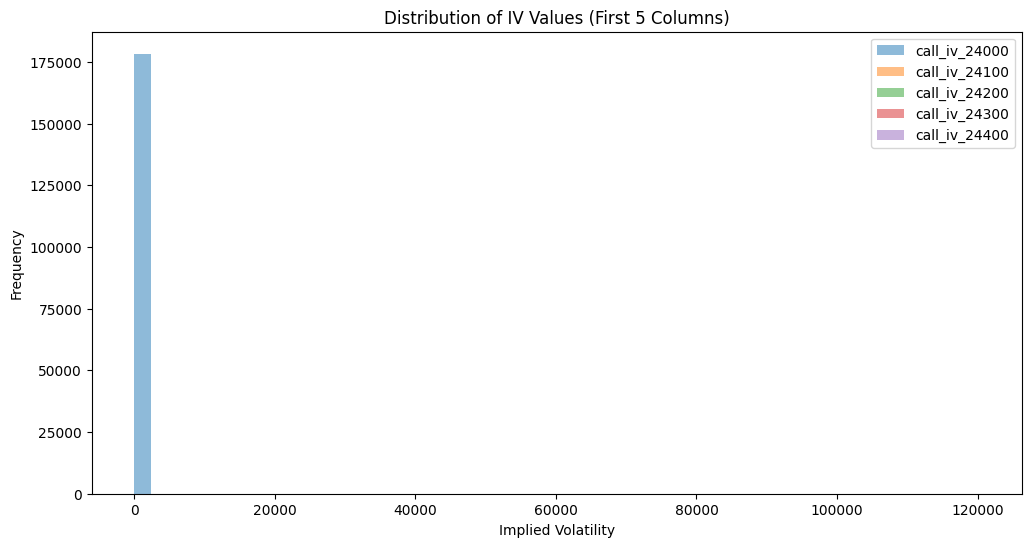

In [4]:
# Plot distribution of IV values in training data
plt.figure(figsize=(12, 6))
for i, col in enumerate(iv_columns[:5]):  # Plot first 5 IV columns
    if col in train.columns:
        plt.hist(train[col].dropna(), bins=50, alpha=0.5, label=col)
plt.title('Distribution of IV Values (First 5 Columns)')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Global statistics:
Mean IV: -12.4045
Median IV: 0.2104
Std IV: 35867.6395


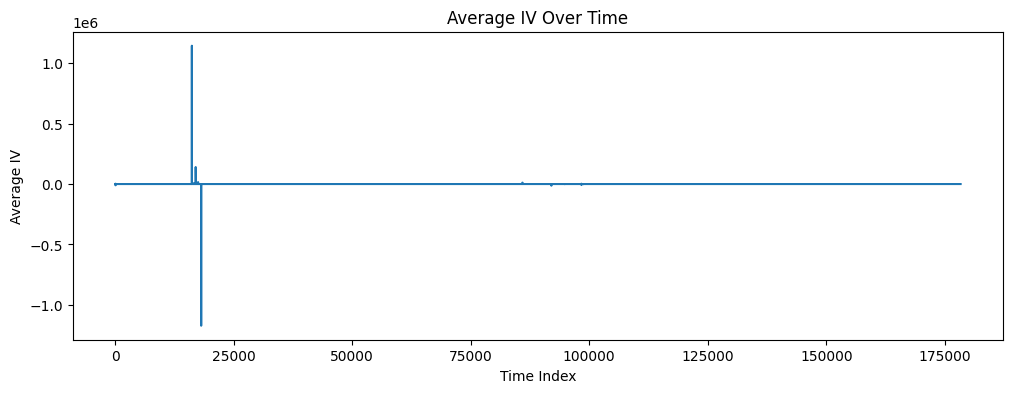

In [5]:
# Pre-calculate enhanced statistics from training data
def calculate_enhanced_stats(data):
    stats = {}
    
    # Global statistics
    all_ivs = []
    for col in iv_columns:
        if col in data.columns:
            valid_ivs = data[col].dropna()
            if len(valid_ivs) > 0:
                all_ivs.extend(valid_ivs.values)
                stats[col] = {
                    'mean': valid_ivs.mean(),
                    'std': valid_ivs.std(),
                    'median': valid_ivs.median(),
                    'q25': valid_ivs.quantile(0.25),
                    'q75': valid_ivs.quantile(0.75)
                }
    
    stats['global'] = {
        'mean': np.mean(all_ivs) if all_ivs else 0.2,
        'std': np.std(all_ivs) if all_ivs else 0.05,
        'median': np.median(all_ivs) if all_ivs else 0.2
    }
    
    # Time-based patterns
    time_patterns = {}
    for t in data['timestamp'].unique():
        time_data = data[data['timestamp'] == t]
        time_ivs = []
        for col in iv_columns:
            if col in time_data.columns:
                valid_ivs = time_data[col].dropna()
                if len(valid_ivs) > 0:
                    time_ivs.extend(valid_ivs.values)
        
        if time_ivs:
            time_patterns[t] = {
                'mean': np.mean(time_ivs),
                'std': np.std(time_ivs) if len(time_ivs) > 1 else stats['global']['std']
            }
    
    stats['time_patterns'] = time_patterns
    return stats

global_stats = calculate_enhanced_stats(train)

print("Global statistics:")
print(f"Mean IV: {global_stats['global']['mean']:.4f}")
print(f"Median IV: {global_stats['global']['median']:.4f}")
print(f"Std IV: {global_stats['global']['std']:.4f}")

# Plot time patterns
time_means = [v['mean'] for v in global_stats['time_patterns'].values()]
plt.figure(figsize=(12, 4))
plt.plot(time_means)
plt.title('Average IV Over Time')
plt.xlabel('Time Index')
plt.ylabel('Average IV')
plt.show()

In [6]:
def extract_strike_price(strike_str):
    try:
        return float(strike_str)
    except:
        return 0.0

def volatility_smile_model(strikes, ivs, target_strike):
    """Enhanced volatility smile modeling using multiple approaches"""
    if len(strikes) < 2:
        return np.mean(ivs) if ivs else global_stats['global']['mean']
    
    strikes = np.array(strikes)
    ivs = np.array(ivs)
    
    # Sort by strike
    sort_idx = np.argsort(strikes)
    strikes = strikes[sort_idx]
    ivs = ivs[sort_idx]
    
    # Method 1: Cubic spline interpolation
    try:
        if len(strikes) >= 3:
            spline = UnivariateSpline(strikes, ivs, k=3, s=0.001)
            spline_pred = spline(target_strike)
            if 0.01 < spline_pred < 1.0:
                return float(spline_pred)
    except:
        pass
    
    # Method 2: Quadratic fit for volatility smile
    try:
        if len(strikes) >= 3:
            # Fit quadratic: IV = a*(K-S)^2 + b*(K-S) + c
            spot_proxy = np.median(strikes)  # Use median strike as spot proxy
            x = strikes - spot_proxy
            coeffs = np.polyfit(x, ivs, 2)
            quad_pred = np.polyval(coeffs, target_strike - spot_proxy)
            if 0.01 < quad_pred < 1.0:
                return float(quad_pred)
    except:
        pass
    
    # Method 3: Linear interpolation/extrapolation
    try:
        f = interp1d(strikes, ivs, kind='linear', bounds_error=False, fill_value='extrapolate')
        linear_pred = f(target_strike)
        if 0.01 < linear_pred < 1.0:
            return float(linear_pred)
    except:
        pass
    
    # Fallback: Distance-weighted average
    distances = np.abs(strikes - target_strike)
    weights = 1 / (distances + 1e-8)
    weighted_iv = np.average(ivs, weights=weights)
    
    return float(np.clip(weighted_iv, 0.01, 1.0))

def temporal_smoothing(data, window=5):
    """Apply temporal smoothing to reduce noise"""
    smoothed_data = data.copy()
    
    for col in iv_columns:
        if col in data.columns:
            # Forward fill first
            smoothed_data[col] = smoothed_data[col].fillna(method='ffill')
            # Backward fill
            smoothed_data[col] = smoothed_data[col].fillna(method='bfill')
            # Apply rolling mean for smoothing
            smoothed_data[col] = smoothed_data[col].rolling(window=window, center=True, min_periods=1).mean()
    
    return smoothed_data

def predict_iv_enhanced(data):
    data = data.copy()
    
    # Phase 1: Enhanced put-call parity with temporal consistency
    for strike, cols in strike_dict.items():
        call_col = cols['call']
        put_col = cols['put']
        
        if call_col in data.columns and put_col in data.columns:
            # Bidirectional filling with slight adjustment for put-call parity
            call_mask = data[call_col].isna() & data[put_col].notna()
            put_mask = data[put_col].isna() & data[call_col].notna()
            
            # Fill with slight adjustment for theoretical put-call parity differences
            data.loc[call_mask, call_col] = data.loc[call_mask, put_col] * 1.001
            data.loc[put_mask, put_col] = data.loc[put_mask, call_col] * 0.999
    
    # Phase 2: Enhanced volatility smile modeling
    for idx, row in data.iterrows():
        current_time = row['timestamp']
        
        # Collect available IV values with their strikes
        available_data = []
        for col in iv_columns:
            if col in row and not pd.isna(row[col]):
                strike = extract_strike_price(col.split('_')[-1])
                available_data.append((strike, row[col]))
        
        if len(available_data) >= 2:
            strikes, ivs = zip(*available_data)
            
            # Fill missing values using enhanced smile model
            for col in iv_columns:
                if col in data.columns and pd.isna(data.at[idx, col]):
                    target_strike = extract_strike_price(col.split('_')[-1])
                    predicted_iv = volatility_smile_model(strikes, ivs, target_strike)
                    data.at[idx, col] = predicted_iv
        
        else:
            # Fallback to time-based patterns
            fallback_value = global_stats['global']['mean']
            if current_time in global_stats['time_patterns']:
                fallback_value = global_stats['time_patterns'][current_time]['mean']
            
            for col in iv_columns:
                if col in data.columns and pd.isna(data.at[idx, col]):
                    data.at[idx, col] = fallback_value
    
    # Phase 3: Cross-sectional consistency enforcement
    for idx, row in data.iterrows():
        strike_iv_pairs = []
        for col in iv_columns:
            if col in data.columns and not pd.isna(data.at[idx, col]):
                strike = extract_strike_price(col.split('_')[-1])
                strike_iv_pairs.append((strike, data.at[idx, col]))
        
        if len(strike_iv_pairs) >= 3:
            strikes, ivs = zip(*strike_iv_pairs)
            strikes = np.array(strikes)
            ivs = np.array(ivs)
            
            # Apply gentle smoothing to maintain smile shape
            try:
                spline = UnivariateSpline(strikes, ivs, k=2, s=0.01)
                for col in iv_columns:
                    if col in data.columns:
                        strike = extract_strike_price(col.split('_')[-1])
                        smoothed_iv = spline(strike)
                        if 0.01 < smoothed_iv < 1.0:
                            # Blend original and smoothed (80% original, 20% smoothed)
                            data.at[idx, col] = 0.8 * data.at[idx, col] + 0.2 * smoothed_iv
            except:
                pass
    
    # Phase 4: Temporal consistency
    data = temporal_smoothing(data, window=3)
    
    # Phase 5: Final put-call parity adjustment
    for strike, cols in strike_dict.items():
        call_col = cols['call']
        put_col = cols['put']
        
        if call_col in data.columns and put_col in data.columns:
            # Final averaging to ensure put-call consistency
            avg_iv = (data[call_col] + data[put_col]) / 2
            data[call_col] = 0.9 * data[call_col] + 0.1 * avg_iv
            data[put_col] = 0.9 * data[put_col] + 0.1 * avg_iv
    
    # Ensure all values are within reasonable bounds
    for col in iv_columns:
        if col in data.columns:
            data[col] = np.clip(data[col], 0.01, 1.0)
    
    return data

In [7]:
# Create validation split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

print(f"Train split size: {len(train_df)}")
print(f"Validation split size: {len(val_df)}")

# Create artificial missing values in validation set for testing
val_test = val_df.copy()
mask_prob = 0.1  # Mask 10% of values randomly
for col in iv_columns:
    if col in val_test.columns:
        mask = np.random.random(len(val_test)) < mask_prob
        val_test.loc[mask, col] = np.nan

print(f"Number of missing values created: {val_test[iv_columns].isna().sum().sum()}")

Train split size: 142672
Validation split size: 35668


KeyError: "['call_iv_26100', 'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500', 'put_iv_25100', 'put_iv_25200', 'put_iv_25300', 'put_iv_25400', 'put_iv_25500'] not in index"

In [ ]:
# Apply enhanced prediction to validation set
val_pred = predict_iv_enhanced(val_test)

# Calculate MSE on masked points
mse_vals = []
for col in iv_columns:
    if col in val_df.columns and col in val_pred.columns:
        # Find originally masked points
        mask = val_test[col].isna() & val_pred[col].notna()
        if mask.any():
            true_vals = val_df.loc[mask, col]
            pred_vals = val_pred.loc[mask, col]
            se = (true_vals - pred_vals) ** 2
            mse_vals.append(se.mean())

validation_mse = np.mean(mse_vals) if mse_vals else 0
print(f"Enhanced Validation MSE: {validation_mse:.12f}")

# Plot example predictions vs actual
example_col = iv_columns[0]
mask = val_test[example_col].isna() & val_pred[example_col].notna()
if mask.any():
    plt.figure(figsize=(12, 4))
    plt.plot(val_df.loc[mask, example_col].values, label='Actual')
    plt.plot(val_pred.loc[mask, example_col].values, label='Predicted')
    plt.title(f'Example Predictions vs Actual for {example_col}')
    plt.legend()
    plt.show()

In [ ]:
# Apply to test set
test_pred = predict_iv_enhanced(test)

# Prepare submission
submission = test_pred[['timestamp'] + iv_columns].copy()
submission.columns = sample_sub.columns

# Final quality checks
assert submission.isna().sum().sum() == 0, "Missing values detected"

# Additional quality check: ensure reasonable IV ranges
for col in iv_columns:
    if col in submission.columns:
        col_vals = submission[col]
        if col_vals.min() < 0.005 or col_vals.max() > 2.0:
            print(f"Warning: {col} has extreme values: min={col_vals.min():.6f}, max={col_vals.max():.6f}")

submission.to_csv('submission.csv', index=False)

print("\nEnhanced Final Submission Preview:")
display(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Enhanced Validation MSE: {validation_mse:.12f}")
print(f"IV Range: {submission[iv_columns].min().min():.6f} to {submission[iv_columns].max().max():.6f}")

# Plot distribution of predicted IVs
plt.figure(figsize=(12, 6))
plt.hist(submission[iv_columns].values.flatten(), bins=50)
plt.title('Distribution of Predicted IV Values in Submission')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Additional diagnostics
print("\nDiagnostics:")
for col in iv_columns[:5]:  # Show first 5 columns
    if col in submission.columns:
        print(f"{col}: mean={submission[col].mean():.6f}, std={submission[col].std():.6f}")

# Plot volatility smile for first timestamp
first_timestamp = submission.iloc[0]
call_ivs = []
put_ivs = []
strikes = []

for strike in strike_values[:10]:  # First 10 strikes
    strike_str = str(strike)
    if strike_str in strike_dict:
        call_col = strike_dict[strike_str]['call']
        put_col = strike_dict[strike_str]['put']
        if call_col in first_timestamp and put_col in first_timestamp:
            call_ivs.append(first_timestamp[call_col])
            put_ivs.append(first_timestamp[put_col])
            strikes.append(strike)

if strikes:
    plt.figure(figsize=(12, 6))
    plt.plot(strikes, call_ivs, 'o-', label='Call IV')
    plt.plot(strikes, put_ivs, 'o-', label='Put IV')
    plt.title('Volatility Smile for First Timestamp')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid()
    plt.show()